In [1]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

ee.Initialize()

In [2]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied
3) Scale (optional): Resolution at which to perform analysis
4) Satellites / datasets: Queried from Earth Engine
'''

##### AREA #####

# HUC 4s draining to the CV 
cv = gp.read_file("../shape/cv.shp")
cv2 = cv.geometry.simplify(0.1)
lls = cv2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)
sa_km3 = round(cv2.area[0] * 10, 2)
        
##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)

##### SCALE #####

In [3]:
data = {}

###################
##### ET data #####
###################

# https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD16A2
data['modis'] = [ee.ImageCollection('MODIS/006/MOD16A2'), "ET", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V020_NOAH_G025_T3H
data['gldas'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'Evap_tavg', 86400]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002
data['nldas'] = [ee.ImageCollection('NASA/NLDAS/FORA0125_H002'), 'potential_evaporation', 1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE
data['terra'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "aet", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET
data['gmet_etr'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "etr", 1]
data['gmet_eto'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "eto", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001
data['fldas'] = [ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001'), "Evap_tavg", 86400*24 ]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001
data['cas'] = [ee.ImageCollection('CAS/IGSNRR/PML/V2'), "ET_water", 1]

###################
##### P data ######
###################

data['trmm']  =  [ee.ImageCollection('TRMM/3B43V7'), "precipitation", 720]
data['prism'] = [ee.ImageCollection("OREGONSTATE/PRISM/AN81m"), "ppt", 1]
data['chirps'] = [ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'), "precipitation", 1]
data['persia'] = [ee.ImageCollection("NOAA/PERSIANN-CDR"), "precipitation", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_ORNL_DAYMET_V3
data['dmet'] = [ee.ImageCollection('NASA/ORNL/DAYMET_V3'), "prcp", 1]

####################
##### DS data ######
####################
data['grace'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "lwe_thickness_jpl", 1]

####################
##### R data #######
####################
data['r'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "ro", 1]
data['runoff'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "Qs_tavg", 86400*24]

#####################
##### SM data #######
#####################

data['sm'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "soil", 0.1]

data['sm1'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi00_10cm_tavg", 1]
data['sm2'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi10_40cm_tavg", 1]
data['sm3'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi40_100cm_tavg", 1]
data['sm4'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi100_200cm_tavg", 1]

In [4]:
def get_data(dataset, year, month):

    col = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]

    t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(area).sum()
    t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
    # convert mm to m, multiply by pixel area (m^2), multiply by scaling factor, m^3 to km^3
    scale = t2.projection().nominalScale()
    sumdict  = t2.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = area,
        scale = scale)
    
    result = sumdict.getInfo()[var] # * 1e-9 # convert m^3 to km^3
    
    return result

def wrapper(dataset):
    monthly = []

    for year in years:
        for month in months:
            r = get_data(dataset, year, month)
            monthly.append(r)
    
    print("wrapper complete")
    return monthly

In [5]:
years = range(2001, 2018)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [6]:
# Fetch Soil Moisture and runoff - warning: takes some time

sm = wrapper(data['sm'])
r = wrapper(data['r'])
# sm1 = wrapper(data['sm1'])
# sm2 = wrapper(data['sm2'])
# sm3 = wrapper(data['sm3'])
# sm4 = wrapper(data['sm4'])

wrapper complete
wrapper complete


In [7]:
# Fetch all ET data - warning: takes very long
et_m = wrapper(data['modis'])
eto_g = wrapper(data['gmet_eto'])
etr_g = wrapper(data['gmet_etr'])
et_f = wrapper(data['fldas'])
et_t = wrapper(data['terra'])
# TODO: gldas, nldas

KeyboardInterrupt: 

In [ ]:
# Fetch all precip data - warning: takes very long
p_p = wrapper(data['prism'])
p_c = wrapper(data['chirps'])
p_n = wrapper(data['persia'])
p_t = wrapper(data['trmm'])
p_d = wrapper(data['dmet'])

In [122]:
# Stack P and ET datasets and calc mean
p_arrs = [np.array(x) for x in [p_p, p_c, p_n, p_t, p_d]]
p_stacked = np.column_stack(p_arrs)
p = np.mean(p_stacked, axis = 1)

et_arrs = [np.array(x) for x in [et_m, eto_g, etr_g, et_f, et_t]]
et_stacked = np.column_stack(et_arrs)
et = np.mean(et_stacked, axis = 1)

In [258]:
# Read c2vsim storage data

data_dir = "../data/"
files = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith(".txt")]

ds = pd.read_csv(files[0], sep='\t', header=0)
ds.set_index(ds['dt'], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)

# remove local timezone
ds = ds.tz_localize(None).copy()
ds.drop(["dt", "region"],axis = 1, inplace = True)
ds['s'] = ds['s'] * 1.23348 # MAF to km^3

# Read USGS Q data
data_dir = "../data/"
files = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith("Qs.csv")]

q= pd.read_csv(files[0], header=0)
q.set_index(q.columns[0], inplace = True)
q.index = pd.to_datetime(q.index)
q.index.name = "date"

# compute monthly sum and convert cms to cubic km / month
q_m = q['discharge_cms'].resample('M').sum() * 1e-9 * 86400
q = pd.DataFrame(q_m)

# Read USGS Reservoir data
res_s = pd.read_csv("../data/reservoir_storage.csv")
res_s.set_index(res_s.columns[0], inplace = True)
res_s.index = pd.to_datetime(res_s.index)
res_s.index.name = "date"

# Read Streamflow IN data
res_s = pd.read_csv("../data/reservoir_storage.csv")
res_s.set_index(res_s.columns[0], inplace = True)
res_s.index = pd.to_datetime(res_s.index)
res_s.index.name = "date"

In [237]:
# Make a df from precip and ET RS data:

years = range(2001, 2018)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

petdf = pd.DataFrame([r, sm, p_p, p_c, p_n, p_t,p_d, et_m, eto_g, etr_g, et_f, et_t, list(p),list(et)]).T

petdf.index = dt_idx

df_temp=pd.merge(petdf,q, how='inner', left_index=True, right_index=True)
df2_temp=pd.merge(df_temp,res_s, how='inner', left_index=True, right_index=True)
df=pd.merge(df2_temp,ds, how='inner', left_index=True, right_index=True)

df.columns = ["runoff", "soil_moisture", "prism", "chirps", "persiann" ,"trmm", "daymet", "modis", "gmet_eto", "gmet_etr", "fldas", "terraclimate", 'p_mean', 'et_mean', "qs","res_s", "c2v_s"]

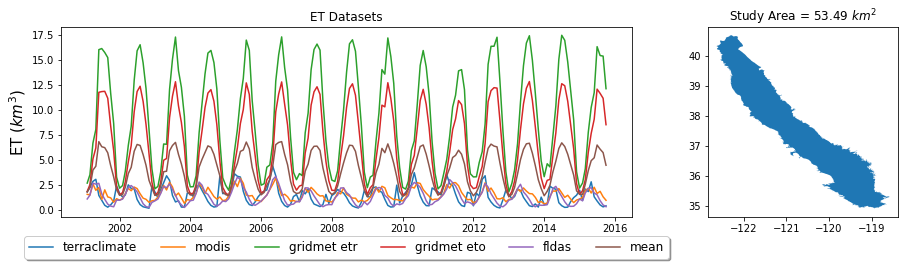

In [238]:
# Plot the ET Datasets

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,3.5))

a0.set_title("ET Datasets")
a0.plot(df.index, df.terraclimate, label = 'terraclimate')
a0.plot(df.index, df.modis, label = "modis")
a0.plot(df.index, df.gmet_etr, label = 'gridmet etr')
a0.plot(df.index, df.gmet_eto, label = 'gridmet eto')
a0.plot(df.index, df.fldas, label = 'fldas')
a0.plot(df.index, df.et_mean, label = 'mean')
a0.set_ylabel('ET $(km^3)$', size = 15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(sa_km3))
cv.plot(ax=a1)

plt.show()

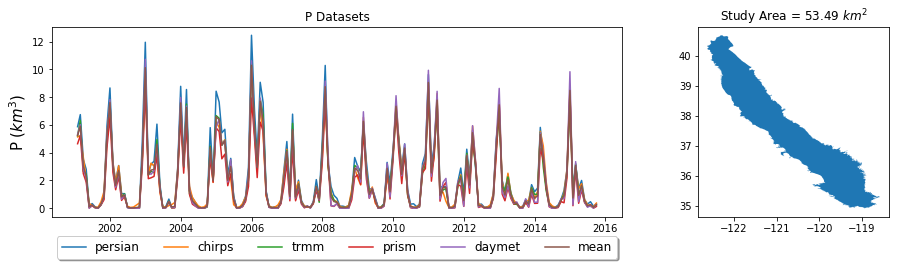

In [239]:
# P datasets

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,3.5))

a0.set_title("P Datasets")

a0.plot(df.index, df.persiann, label = 'persian')
a0.plot(df.index, df.chirps, label = "chirps")
a0.plot(df.index, df.trmm, label = 'trmm')
a0.plot(df.index, df.prism, label = 'prism')
a0.plot(df.index, df.daymet, label = 'daymet')
a0.plot(df.index, df.p_mean, label = 'mean')
a0.set_ylabel('P $(km^3)$', size = 15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(sa_km3))
cv.plot(ax=a1)

plt.show()

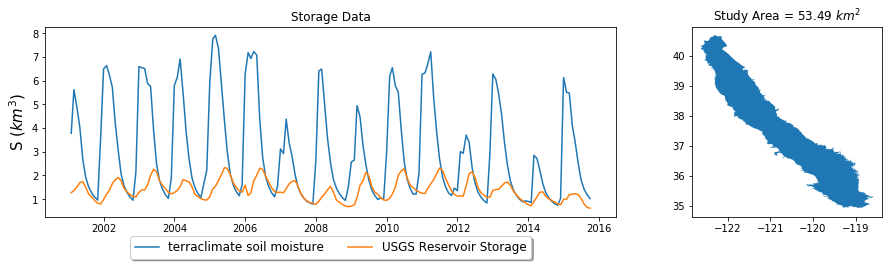

In [240]:
# SM data

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,3.5))

a0.set_title("Storage Data")

a0.plot(df.index, df.soil_moisture, label = 'terraclimate soil moisture')
a0.plot(df.index, df.res_s, label = 'USGS Reservoir Storage')

a0.set_ylabel('S $(km^3)$', size = 15)
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(round(sa_km3, 3)))
cv.plot(ax=a1)

plt.show()

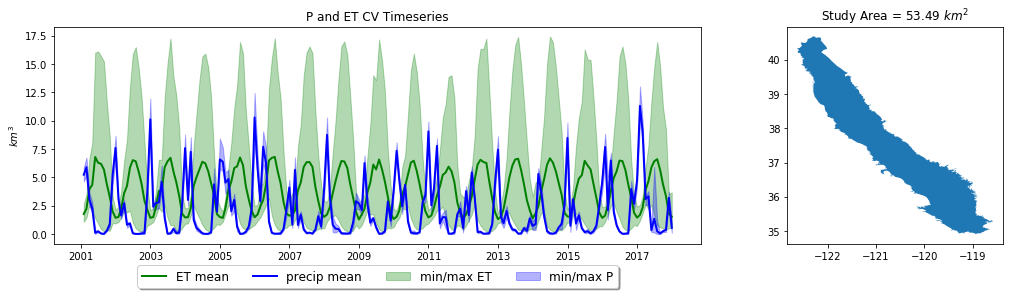

In [241]:
# Plot the means and ranges
f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(17,4))

a0.set_title("P and ET CV Timeseries")

a0.plot(dt_idx, et, label = "ET mean", color = "green", linewidth=2.0)
a0.fill_between(dt_idx, np.min(et_stacked, axis = 1), np.max(et_stacked, axis = 1), alpha = 0.3, color = "green", label = "min/max ET")

a0.plot(dt_idx, p, label = "precip mean", color = "blue", linewidth = 2.0)
a0.fill_between(dt_idx, np.min(p_stacked, axis = 1), np.max(p_stacked, axis = 1), alpha = 0.3, color = "blue", label = "min/max P")
a0.set_ylabel("$km^3$")
a0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

a1.set_title("Study Area = {} $km^2$".format(sa_km3))
cv.plot(ax=a1)

plt.show()

In [392]:
# save the csv
# df.to_csv("../data/rs_data_cv.csv")

# Calc the balance
df['ds'] = df.p_mean - df.et_mean - df.qs + df.soil_moisture
df['ds2'] = df.p_mean - df.et_mean - df.qs + df.soil_moisture

177

In [387]:
# plt.figure(figsize=(15,6))
# plt.plot(df.prism, label = "p")
# plt.plot(df.et_mean, label = "et")
# plt.plot(df.qs, label = "qs")
# plt.plot(df.soil_moisture, label = "sm")
# plt.plot(df.res_s, label = "res")
# # plt.plot(df.ds, label = "ds")
# plt.legend()
# plt.show()

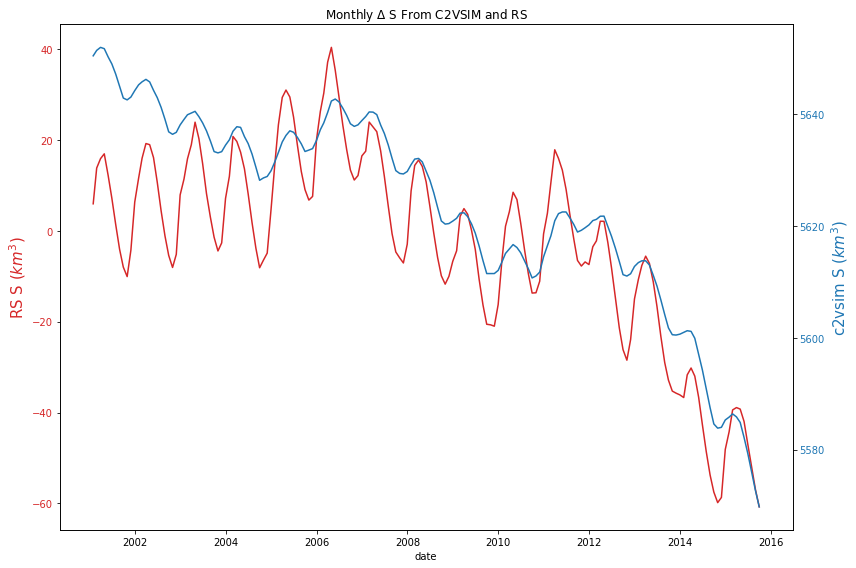

In [397]:
# Plot c2vsim DS and RS DS

fig, ax1 = plt.subplots(figsize = (12,8))
plt.title("Monthly $\Delta$ S From C2VSIM and RS")

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('RS S $(km^3)$', color=color, size = 15)
ax1.plot(df.index, np.cumsum(df.ds), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('c2vsim S ($km^3$)', color=color, size = 15)  
ax2.plot(df.index, df.c2v_s, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

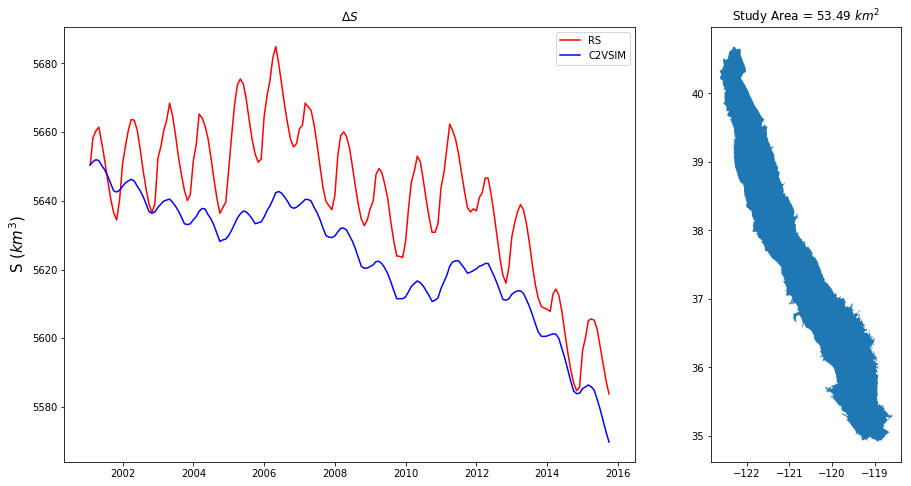

In [389]:
# plot on same axis

f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]}, figsize=(15,8))

a0.set_title("$\Delta S$")
a0.plot(df.index, np.cumsum(df.ds)+df.c2v_s.iloc[0] - df.ds.iloc[0], color="red", label = "RS")
a0.plot(df.index, df.c2v_s, color="blue", label = "C2VSIM")
a0.set_ylabel('S $(km^3)$', size = 15)
a0.legend()

a1.set_title("Study Area = {} $km^2$".format(sa_km3))
cv.plot(ax=a1)


In [308]:
# Compute annual ds sums from ds = P - ET - Q:
years = np.arange(df.index[0].year, df.index[-1].year-1)

rs_sums = {}
c2v_sums = {}

startmonth = 11

for year in years:

    # Select df for nov and the first year
    ydf1 = df.iloc[df.index.year == year]
    mdf1 = ydf1.iloc[ydf1.index.month == startmonth]
    
    # advance a year and select df
    nextyear_df = df.iloc[df.index.year == year+1]
    nextmonth_df = nextyear_df.iloc[nextyear_df.index.month == startmonth-1]
    
    # subset original df based on start and end indices
    hydro_year_df = df.loc[mdf1.index[0] : nextmonth_df.index[0]]
    
    # compute the sums
    c2v_sums[year] = hydro_year_df['c2v_s'][-1] - hydro_year_df['c2v_s'][0]
    rs_sums[year] = hydro_year_df['ds'].sum()
    

In [268]:
dt_y = pd.date_range(start=df.index[0], end=df.index[-1] + relativedelta(years=-1),  freq='Y')
ds_df = pd.DataFrame({'ds':list(rs_sums.values()), 'c2vds': list(c2v_sums.values())})
ds_df.index = dt_y

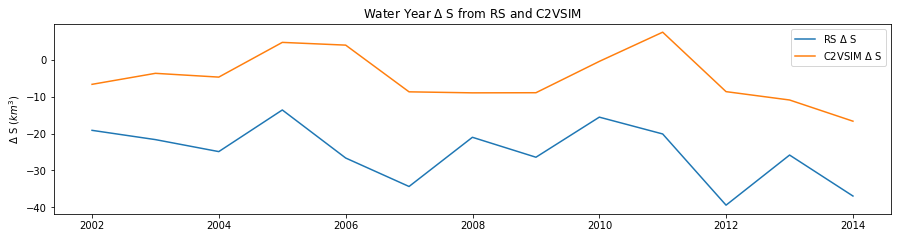

In [269]:
plt.figure(figsize = (15,3.5))
plt.title("Water Year $\Delta$ S from RS and C2VSIM")
plt.plot(ds_df.index,ds_df.ds, label = "RS $\Delta$ S")
plt.plot(ds_df.index,ds_df.c2vds, label = "C2VSIM $\Delta$ S")
plt.ylabel("$\Delta$ S $(km^3)$")
plt.legend()
plt.show()

# Scaling: 
## $ X_{scaled} = \frac{X_i - \mu}{\sigma_x}$

In [270]:
mms = sklearn.preprocessing.StandardScaler()

scaled = []

for i in [ds_df['ds'],ds_df['c2vds']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


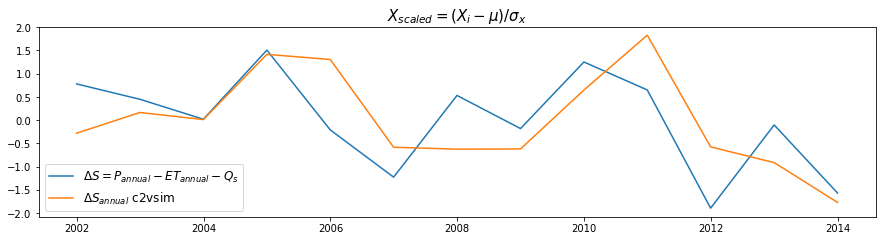

In [271]:
plt.figure(figsize=(15,3.5))

plt.title("$ X_{scaled} = ({X_i - \mu})/{\sigma_x}$", size = 15)
plt.plot(dt_y, scaled[0], label = "$\Delta S = P_{annual} - ET_{annual} - Q_{s}$")
plt.plot(dt_y, scaled[1], label = "$\Delta S_{annual}$ c2vsim")
plt.legend(loc="lower left", fontsize = 'large')

plt.show()